In [1]:
import sys
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.stats import norm

sys.path.insert(0,'..')
from src.black_scholes import BlackScholes
from src.monte_carlo import MLMC

In [2]:
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

# Multilevel Monte Carlo (MLMC)

The concept of Multilevel Monte Carlo and the basis of this entire notebook is [Multilevel Monte Carlo path simulation](https://ora.ox.ac.uk/objects/uuid:d9d28973-94aa-4179-962a-28bcfa8d8f00/download_file?safe_filename=2007OMI06.pdf&file_format=application%2Fpdf&type_of_work=Working+paper) by Michael B. Giles. Without going too much into detail, we would like to explain the basic idea behind this very exciting topic, and prove the results empirically.

### The idea behind MLMC

The idea of MLMC is to solve for a specific quantity of interest using **different levels of discretization**. Using a relatively big step size $\tau$ for the Euler-Maruyama method leads to relatively big errors, but computation takes place at small cost. A very fine step size $\tau$ leads to more precise results, which in turn are computationally more expensive. MLMC combines the strengths of different discretization levels to obtain a more efficient estimator with lower variance overall. The combination is given by the telescoping sum identity

$$
\mathbb{E}[\hat{P}_L] = \mathbb{E}[\hat{P}_0] + \sum_{l=1}^L \mathbb{E}[\hat{P}_l - \hat{P}_{l-1}],
$$

where $\hat{P}_l$ denotes the level-$l$-approximation to the option value using the step size $\tau_l$. So all of the $\hat{P}_l$ approximate the same option value, but on different discretization levels. We use the simple mean estimator

$$
\hat{Y}_0 = m_0^{-1} \sum_{i=1}^{m_0} \hat{P}_0^{(i)}
$$

with $m_0 \in \mathbb{N}$ samples for approximating $\mathbb{E}[\hat{P}_0]$, and

$$
\hat{Y}_l = m_l^{-1} \sum_{i=1}^{m_l} \left(\hat{P}_l^{(i)} - \hat{P}_{l-1}^{(i)}\right)
$$

for estimating $\mathbb{E}[\hat{P}_l - \hat{P}_{l-1}]$. The key point here is that the quantity $\hat{P}_l^{(i)} - \hat{P}_{l-1}^{(i)}$ comes from two approximations with different timesteps $\tau_l$ but the same Wiener path $W_t^{(i)}$. Thus the combined estimator is

$$
\hat{Y} = \sum_{l=0}^{L} \hat{Y}_l
$$

with a minimal variance achieved by choosing optimal sample sizes $m_l$ for each level. The strong and weak order of the SDE solver play a particularly important role here. The exact choice of sample sizes $m_l $ can be found in the paper above, or in our source code.


### Standard Monte Carlo cost

The mean squared error (MSE) for approximating an option value using standard Monte Carlo is asymptotically of the form

$$
\text{MSE} \in \mathcal{O}(m^{-1}) + \mathcal{O}(\tau^2),
$$

where $m \in \mathbb{N}$ denotes the number of samples for Monte Carlo and $\tau > 0$ the time step for the Euler-Maruyama method. Thus, in order to achieve MSE $\mathcal{O}(\varepsilon^2)$, it is required that $m \in \mathcal{O}(\varepsilon^{-2})$ and $\tau \in \mathcal{O}(\varepsilon)$, with a total cost of $m / h \in \mathcal{O}(\varepsilon^{-3})$. 

### Improved MLMC costs

The main theorem in the paper proves that the above total cost can be reduced to $\mathcal{O}(\varepsilon^{-2} (\log{}\varepsilon)^2)$ using MLMC with Euler-Maruyama, and even to $\mathcal{O}(\varepsilon^{-2})$ using the Milstein method!

## European call option params

Let's price a European call.

In [3]:
option_params = {
    "s0": 55,
    "K": 50,
    "r": 0.05,
    "sigma": 0.1,
    "T": 1,
    "option_type": 'call',
}

In [4]:
bs_val = BlackScholes(t=0, **option_params)
print(f"Black-Scholes: {bs_val:.3f}")

Black-Scholes: 7.605


Following the [papers](https://ora.ox.ac.uk/objects/uuid:d9d28973-94aa-4179-962a-28bcfa8d8f00/download_file?safe_filename=2007OMI06.pdf&file_format=application%2Fpdf&type_of_work=Working+paper) suggestion, we choose to half the step size $\tau_l = M^{-l}\,T$ at each level $l \in \mathbb{N}$ with $M=2$. Let's also fix a desired precision $\varepsilon = 0.01$ for our option value and test the MLMC method.

In [5]:
M = 2
eps = .01

MLMC_estimator = MLMC(M, eps)
val, sample_sizes = MLMC_estimator.fit(option_params, solver="EM")
print(f"Option value: {val:.3f}")
print(f"Used sample sizes: {sample_sizes}")

Option value: 7.591
Used sample sizes: [686047, 26321, 13169, 6466]


Seems to work. The highest level $L \in \mathbb{N}$ (here $L=3$) as well as the sample sizes are determined by the algorithm, since they depend on not a-priori known constants in theory. We can clearly see how the MLMC algorithm combines many cheap samples such as $m_0 = 686.278$, with a few expensive ones like $m_3 = 6.373$.

### Total work

We define the computational work as the total number of timesteps performed on all levels, that is
$$
C = m_0 + \sum_{l=1}^L m_l \left(M^l + M^{l-1}\right).
$$

In [6]:
total_work = lambda m_ls: (
    np.sum(m_ls * np.hstack((1, (M + 1) * M ** np.arange(len(m_ls) - 1))))
)
costs_level_l = lambda sample_sizes: (
    [list(samples * M ** np.arange(len(samples))) for samples in sample_sizes]
)

To verify the main result of the paper, we use 25 different values for the precision $\varepsilon > 0$ and investigate sample sizes, costs at each level and of course the total work. We compare the **Euler-Maruyama method** and the **Milstein method**.

The following cell takes a few seconds to finish.

In [7]:
epsilons = np.logspace(-3., -1., 25)
sample_sizes_EM, sample_sizes_MIL = [], []
comp_costs_EM, comp_costs_MIL = [], []

for eps in tqdm(epsilons):
    _, sample_sizes = MLMC(M, eps).fit(option_params, solver="EM")
    sample_sizes_EM.append(sample_sizes)
    comp_costs_EM.append(total_work(sample_sizes))

    _, sample_sizes = MLMC(M, eps).fit(option_params, solver="MIL")
    sample_sizes_MIL.append(sample_sizes)
    comp_costs_MIL.append(total_work(sample_sizes))

    T = option_params["T"]
cost_level_l_EM = costs_level_l(sample_sizes_EM)
cost_level_l_MIL = costs_level_l(sample_sizes_MIL)

  0%|          | 0/25 [00:00<?, ?it/s]

A closer look at the [paper](https://ora.ox.ac.uk/objects/uuid:d9d28973-94aa-4179-962a-28bcfa8d8f00/download_file?safe_filename=2007OMI06.pdf&file_format=application%2Fpdf&type_of_work=Working+paper) reveals that the costs on level $l$ for Euler-Maruyama are constant, that ist $\mathcal{O} \left(1\right)$, while for Milstein they are apparently $\mathcal{O} \left(\sqrt{\tau_l}\right)$.

Let's plot the costs per level $l$ along with the sample sizes $m_l$ used at level $l$ for both methods. Each of the 25 lines corresponds to one of accuracy values $\varepsilon > 0$.

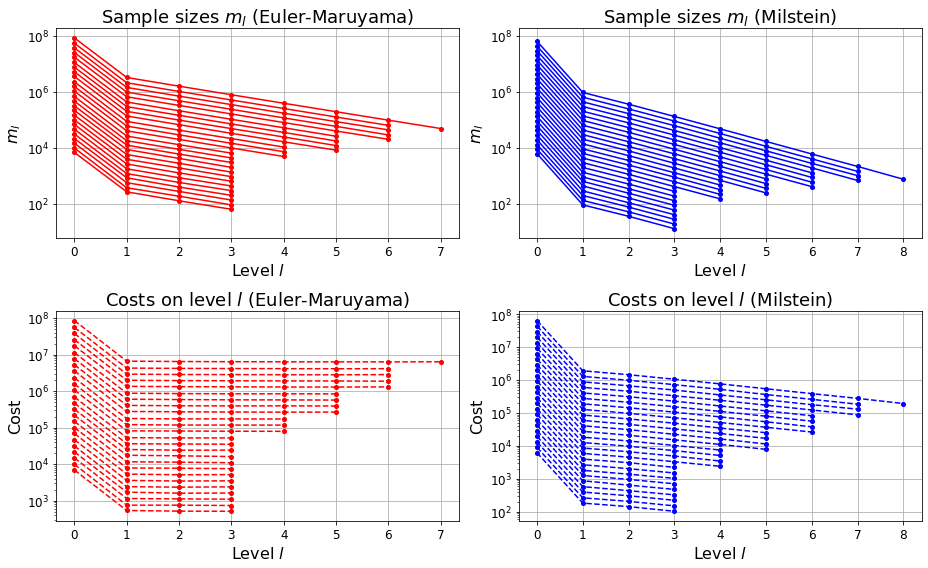

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))
ax = ax.ravel()
ax[0].get_shared_y_axes().join(ax[0], ax[1])
ax[0].get_shared_x_axes().join(ax[1], ax[3])
for i in range(len(epsilons)):
    ax[0].semilogy(sample_sizes_EM[i], 'ro-', markersize=4)
    ax[1].semilogy(sample_sizes_MIL[i], 'bo-', markersize=4)
    ax[2].semilogy(cost_level_l_EM[i], 'ro--', markersize=4)
    ax[3].semilogy(cost_level_l_MIL[i], 'bo--', markersize=4)
    
ax[0].set_xticks(range(max([len(s) for s in sample_sizes_EM])))
ax[1].set_xticks(range(max([len(s) for s in sample_sizes_MIL])))
ax[0].set_title('Sample sizes $m_l$ (Euler-Maruyama)', size=18)
ax[1].set_title('Sample sizes $m_l$ (Milstein)', size=18)
ax[2].set_title('Costs on level $l$ (Euler-Maruyama)', size=18)
ax[3].set_title('Costs on level $l$ (Milstein)', size=18)

for axis in ax:
    axis.set_xlabel(r"Level $l$")
    axis.grid()
    
ax[0].set_ylabel(r'$m_l$')
ax[1].set_ylabel(r'$m_l$')
ax[2].set_ylabel('Cost')
ax[3].set_ylabel('Cost')

plt.tight_layout()

Indeed, the costs on level $l$ seem to be constant for the Euler-Maruyama method, while the costs for Milstein are dropping. It is interesting to note that the different strong orders of the methods lead to a different distribution of the computational work accross the levels. It can also be seen in the upper plots that the sample sizes for Milstein fall much faster, but that the calculations are usually carried out with one level higher than with Euler-Maruyama.

### Verifying $\mathcal{O} (\varepsilon^{-2} (\log \varepsilon)^2)$ for the computational work

Let us now look at the claimed order of convergence of the two methods in combination with MLMC for total work.

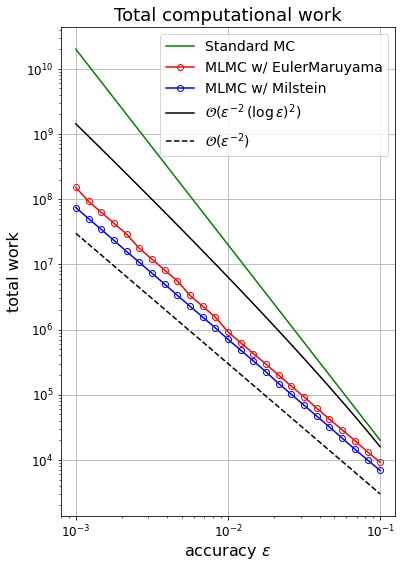

In [36]:
fig = plt.figure(figsize=(6, 9))
plt.loglog(epsilons, 20 * epsilons**-3, 'g', label='Standard MC')
plt.loglog(epsilons, comp_costs_EM, 'ro-', markersize=6, fillstyle='none', label='MLMC w/ EulerMaruyama')
plt.loglog(epsilons, comp_costs_MIL, 'bo-', markersize=6, fillstyle='none', label='MLMC w/ Milstein')
plt.loglog(epsilons, 30 * epsilons**-2 * np.log(epsilons)**2, 'k', label=r'$\mathcal{O} (\varepsilon^{-2} \, (\log{}\varepsilon)^2)$')
plt.loglog(epsilons, 30 * epsilons**-2, 'k--', label=r'$\mathcal{O} (\varepsilon^{-2})$')
plt.xlabel(r'accuracy $\varepsilon$')
plt.ylabel('total work')
plt.title('Total computational work', size=18)
plt.grid()
plt.legend();